# Recognizing Numbers in MNIST Dataset

Today's exercise is focused on recognition of hand written digits from the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).

You also need a [Pillow](https://pillow.readthedocs.io/en/stable/) package in your Python virtual env. Install it by running: `pip install Pillow`.

A brief introduction to MNIST and own model is described in [PyTorch 1.2 Quickstart with Google Colab](https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d) or [A Gentle Introduction to PyTorch 1.2](https://medium.com/dair-ai/pytorch-1-2-introduction-guide-f6fa9bb7597c).

In [307]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow# as pyplot_imshow

In [308]:
def my_imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Convolutional Network

For detection adn recongnition, we'll use a [LeNet model](https://en.wikipedia.org/wiki/LeNet).

In [309]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        # Max-pooling
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        # Convolution
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)
        # Fully connected layer
        self.fc1 = torch.nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = torch.nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = torch.nn.Linear(84, 10)        # convert matrix with 84 features to a matrix of 10 features (columns)
        
    def forward(self, x):
        # convolve, then perform ReLU non-linearity
        x = F.relu(self.conv1(x))  
        # max-pooling with 2x2 grid
        x = self.max_pool_1(x)
        # convolve, then perform ReLU non-linearity
        x = F.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x = x.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        x = F.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = F.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        
        return x

### Model Training

We train the model. You can use saved loss in a text file for charting.

In [310]:
def train(data, model):
    model.train()

    learning_rate = 0.01
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    num_epochs = 5
    p = 1
    with open("loss.txt", "wt") as f:
        for epoch in range(num_epochs):
            running_loss = 0.0
            for i, sample in enumerate(data, 0):
                optimizer.zero_grad()            
                #print(sample[0])
                #print(sample[1])
                inputs = sample[0]
                #img = np.reshape(inputs, (1, 1, 28, 28)) / 255
                #img = torch.from_numpy(img)
                #img = img.type(torch.FloatTensor)
                labels = sample[1]
                
                output = model(inputs)
                loss = criterion(output, labels)
                
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if i % 500 == 499:    # print every 500 mini-batches
                    print('[%d, %d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
                    s = "{0} {1}\n".format(p, running_loss / 500)
                    f.write(s)
                    p += 1
                    running_loss = 0.0

    torch.save(model.state_dict(), './model.pth')

### Model Validation

We validate our trained model to the validation set.

You can enable/disable displaying of each wrongly recognized image by changing the value of `show_image` variable.

In [311]:
def validation(data, model):
    model.eval()
    print("Validating...")
    show_image = False

    size = len(data)
    num_incorrect = 0
    i = 0
    for sample in data:
        images, labels = sample
        #img = transforms.functional.to_pil_image(images[0][0], mode='L')
        #img.save("img_{}.png".format(i), "png")
        output = model(images)
        predicted = torch.max(output.data, 1)
        if labels[0] != predicted[1].item():
            num_incorrect += 1
            if show_image: 
                s = "Real: {0}\t Predicted: {1}".format(labels[0], predicted[1].item())
                print(s)
                my_imshow(torchvision.utils.make_grid(images))
        i += 1
    print("Validation Error: {0} %".format(100.0 * num_incorrect / size))

### Your Task

Implement a sliding window to recognize numbers in any location in a given image. We do not expect numbers to be rotated, so this is much simplified.

You're expected to draw a rectangle around each detected number.

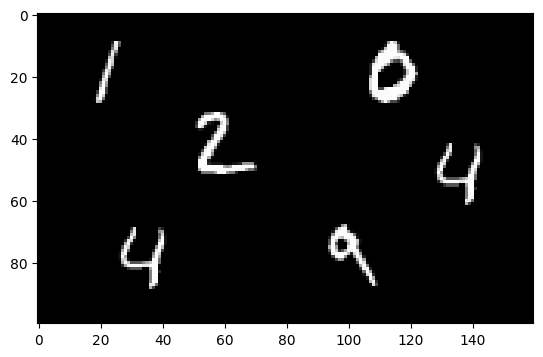

In [312]:
# Here we use an RGB version of image, so it can be displayed.
# In your expiriment, use 'numbers.png'
numbers_img = Image.open('numbers_rgb.png')

imshow(np.asarray(numbers_img))

In [313]:
from PIL import ImageFont, ImageDraw, ImageEnhance

def sliding_window(model, image: Image.Image, size):
    """
    Implement a sliding window to recognize numbers in any location in a given image.
    We do not expect numbers to be rotated, so this is much simplified.
    """
    threshold = 0.95

    if image.mode == "LA":
        image = image.convert("L")
        image.show()

    window_width, window_height = size
    
    stride_width = window_width / 4
    stride_height = window_height / 4

    img_width, img_height = image.size

    # Slide window in x direction and then in y direction
    for y in range(int(img_height/stride_height)):
        
        if y * stride_height + window_height >= img_height:
            print("Window outside img_height")
            continue

        for x in range(int(img_width/stride_width)):
            if x * stride_width + window_width >= img_width:
                print("Window outside img_width")
                continue
            
            x_start = x * stride_width
            y_start = y * stride_height
            
            # Crop our window
            window = image.crop((x_start, y_start, x_start + window_width, y_start + window_height))

            # Apply NN
            # data = torchvision.transforms.functional.pil_to_tensor(window)
            data = torchvision.transforms.functional.to_tensor(window)
            output = model(data)
            softmax = torch.nn.Softmax(dim=1)
            output = softmax(output)
            predicted_out, predicted_num = torch.max(output.data, 1)

            # Draw rectangle if output is higher than threshold
            if predicted_out > threshold:
                print(f"Window matched digit {predicted_num}")
                draw = ImageDraw.Draw(image)
                draw.rectangle([(x_start, y_start), (x_start + window_width, y_start + window_height)], outline=(128))
                draw.text((x_start, y_start), f"Num: {predicted_num.item()}", anchor="lt", fill=(128))

    image.show()
            
            

### Run the Whole Thing

On the first run, `DataLoader` will download MNIST dataset using `torchvision`'s class.

Also, one trained you don't have to train the model on the next run, just uncoment the `torch.load_state_dict` line and comment `model = LeNet()` and `train` function.

Uncoment `sliding_window` to test your implementation.

In [314]:
def main():
    transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(), torchvision.transforms.Resize(28), torchvision.transforms.ToTensor()])
    
    batch_size_train = 16

    train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=batch_size_train, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform))

    #trainfolder = datasets.ImageFolder("train", transform)
    #train_loader = torch.utils.data.DataLoader(trainfolder, batch_size=batch_size_train, shuffle=True)
    
    # create instance of a model
    model = LeNet()
    
    # train new model
    # train(train_loader, model)
        
    # use existing model
    model.load_state_dict(torch.load('./model.pth'))
    
    validation(test_loader, model)
    
    # Save the model
    # torch.save(model.state_dict(), "model.pth")

    # uncoment to run sliding window
    img = Image.open('numbers.png')
    sliding_window(model, img, (28, 28))

Validating...
Validation Error: 1.76 %


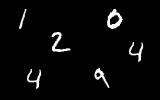

Window matched digit tensor([4])
Window outside img_width
Window outside img_width
Window outside img_width
Window matched digit tensor([1])
Window matched digit tensor([2])
Window outside img_width
Window outside img_width
Window outside img_width
Window matched digit tensor([1])
Window matched digit tensor([4])
Window outside img_width
Window outside img_width
Window outside img_width
Window matched digit tensor([5])
Window outside img_width
Window outside img_width
Window outside img_width
Window matched digit tensor([2])
Window outside img_width
Window outside img_width
Window outside img_width
Window outside img_width
Window outside img_width
Window outside img_width
Window matched digit tensor([5])
Window matched digit tensor([7])
Window matched digit tensor([7])
Window outside img_width
Window outside img_width
Window outside img_width
Window outside img_width
Window outside img_width
Window outside img_width
Window outside img_width
Window outside img_width
Window outside img_w

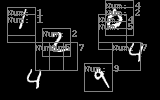

In [315]:
if __name__ == '__main__':
    main()